# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
import datetime, os

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


# Define the functions to test

In [3]:
# Define vector function with three scalar functions
def f_sum_decomposable(x):
    x1, x2 = x[:,0], x[:,1]
    f1 = np.sin(2*np.pi*x1) + np.cos(2*np.pi*x2)
    f2 = np.cos(2*np.pi*x1) + np.sin(2*np.pi*x2)
    f3 = np.cos(2*np.pi*x1) + np.tanh(2*np.pi*x2)
    return np.stack([f1, f2, f3], axis=1)   



[[-1.         -1.        ]
 [-0.97979798 -1.        ]
 [-0.95959596 -1.        ]
 ...
 [ 0.95959596  1.        ]
 [ 0.97979798  1.        ]
 [ 1.          1.        ]]


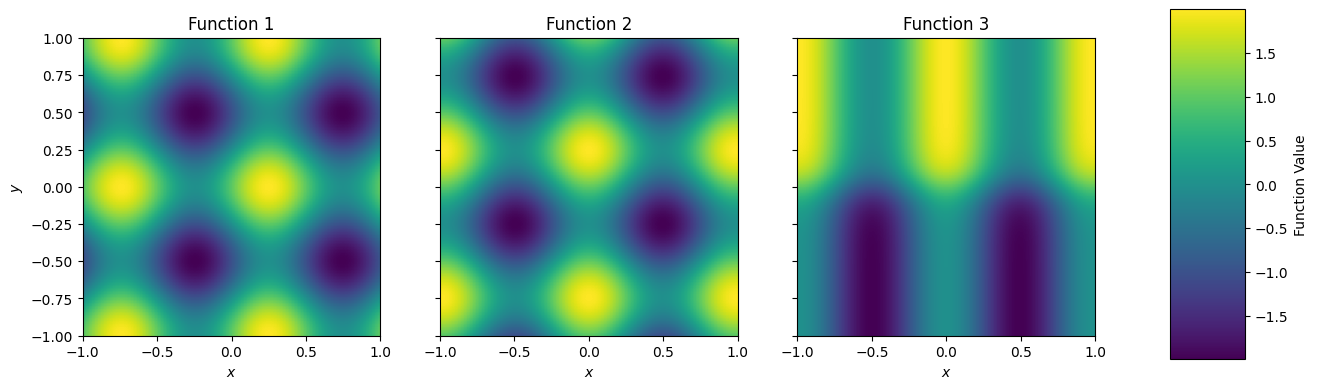

In [4]:
# Create a grid of points in the domain [0, 1]^2
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X,Y = np.meshgrid(x,y)
coordinates = np.stack([X.flatten(), Y.flatten()]).T

print(coordinates)

f = f_sum_decomposable
# Compute the function values at the grid points for each functions
Z = f(coordinates)
Z = Z.reshape(100,100,3)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
fig.subplots_adjust(right=0.8)

cmap="viridis"
titles=['Function 1', 'Function 2', 'Function 3']
for idx in range(3):
    im = axs[idx].imshow(Z[:,:,idx], extent=[-1, 1, -1 ,1], origin='lower', cmap=cmap)
    axs[idx].set_xlabel('$x$')
    axs[idx].set_title(titles[idx])

axs[0].set_ylabel('$y$')

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Function Value')

#plt.savefig('target_function.png', dpi=300, bbox_inches='tight')
#plt.close()
plt.show()

# Model Definition


In [5]:
#using pytorch to create the neural network that will be used to approximate the three functions
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 40)
        self.fc3 = nn.Linear(40, 40)
        self.fc4 = nn.Linear(40, 40)
        self.fc5 = nn.Linear(40, 40)
        self.fc6 = nn.Linear(40, 40)
        self.fc7 = nn.Linear(40, 40)
        self.fc8 = nn.Linear(40, 40)
        self.fc9 = nn.Linear(40, 40)
        self.fc10 = nn.Linear(40, 3)
        


    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = torch.relu(self.fc7(x))
        x = torch.relu(self.fc8(x))
        x = torch.relu(self.fc9(x))
        x = self.fc10(x)
        return x
    



# Control Optimizer Def

In [6]:
# Create the neural network
model = Net().to(device)

# Define the optimizer sgd
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Define the loss function
criterion = nn.MSELoss()

# Create a DataLoader object
coordinates_tensor = torch.tensor(coordinates, dtype=torch.float32).to(device)
dataset = TensorDataset(coordinates_tensor)
dataloader = DataLoader(dataset, batch_size=100)





# COSGD model definitions


C:\Users\rayde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


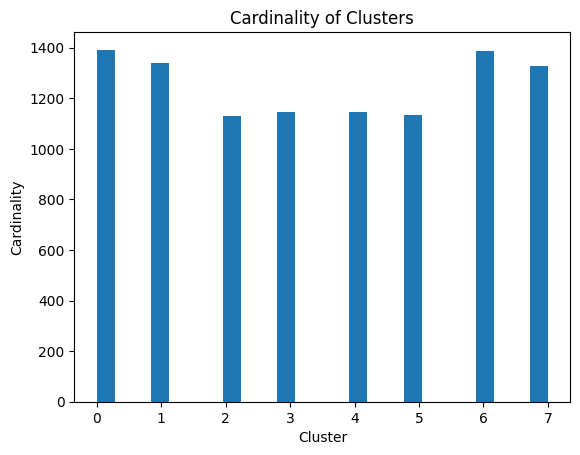

In [7]:
#using kmeans, partition the coordinates into 25 clusters
kmeans = KMeans(n_clusters=8, random_state=0).fit(coordinates)
clusters = kmeans.labels_

#plot the cardinality of each cluster
plt.hist(clusters, bins=25)
plt.xlabel('Cluster')
plt.ylabel('Cardinality')
plt.title('Cardinality of Clusters')
plt.show()

#make a df containing the coordinates and the cluster they belong to
df = pd.DataFrame(coordinates, columns=['x', 'y'])
df['cluster'] = clusters


In [8]:


#Define the custom optimizer
class COSGD(optim.Optimizer):
    def __init__(self, params, lr):
        defaults = dict(lr=lr)
        super(COSGD, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                p.data.add_(-group['lr'], d_p)
        
        return loss

def flatten_grads(grads):
    grads = torch.cat([grad.view(-1) for grad in grads])
    return grads

def unflatten_grads(flattened_grads, model):
    grads = []
    start = 0
    for param in model.parameters():
        end = start + param.numel()
        grads.append(flattened_grads[start:end].view(param.size()))
        start = end
    return grads

def sort_grads(grads, sort_order=True):
    avg_abs = [torch.mean(torch.abs(grad)).item() for grad in grads]
    order = sorted(range(len(avg_abs)), key=lambda i: avg_abs[i], reverse=sort_order)
    return order

def unsort_grads(grads, order):
    unsorted_grads = [grads[i] for i in order]
    return unsorted_grads

def orthogonalize_grads(grads):
    flattened_grads = [flatten_grads(cluster_grads) for cluster_grads in grads]

    #sort the vectors by average absolute value in descending order
    order = sort_grads(flattened_grads)
    flattened_grads = [flattened_grads[i] for i in order]

    #now we have a set of vectors, we can perform the gram schmidt process
    ortho_grads = []
    for i, grad in enumerate(flattened_grads):
        for j in range(i):
            #subtract the projection of the current vector onto the previous vectors
            if torch.norm(ortho_grads[j]) != 0:
                grad = grad - (grad @ ortho_grads[j]) / (ortho_grads[j] @ ortho_grads[j]) * ortho_grads[j]
        ortho_grads.append(grad)
    #sort the vectors back to their original order
    ortho_grads = unsort_grads(ortho_grads, order)
    return ortho_grads

In [9]:
#prepare dataloaders for each cluster
#loop size is equal to the min cardinality of a cluster divided by the batch size
max_cardinality = df['cluster'].value_counts().max()
batch_size = 100
num_mini_batches = max_cardinality // batch_size

dataloaders = []
for i in range(4):
    cluster = df[df['cluster'] == i]
    cluster_tensor = torch.tensor(cluster[['x', 'y']].values, dtype=torch.float32).to(device)
    dataset = TensorDataset(cluster_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    dataloaders.append(dataloader)

def train_model_cosgd(model, optimizer, dataloaders, loss_function, epochs):
    criterion = loss_function
    model.train()
    best_loss = float('inf')
    patience = 0

    for epoch in range(epochs):

        clustered_mini_batches = [[] for _ in range(num_mini_batches+1)]
        for dataloader in dataloaders:
            for i, data in enumerate(dataloader):
                clustered_mini_batches[i].append(data[0])

        #print the shape of clustered_mini_batches
        #print([len(mini_batch) for mini_batch in clustered_mini_batches])

        #print the data in each mini batch
        # for i, mini_batch in enumerate(clustered_mini_batches):
        #     print('Mini-Batch set ', i)
        #     for data in mini_batch:
        #         print(len(data))

        #now we have all the relevant data in each mini batch, we need to loop through the mini batches and apply the normal algorithm
        for i, mini_batch in enumerate(clustered_mini_batches):
            grad_updates = []
            optimizer.zero_grad()
            for j, data in enumerate(mini_batch):
                outputs = model(data)
                targets = torch.tensor(f(data.cpu().numpy()), dtype=torch.float32).to(device)
                loss = criterion(outputs, targets)
                optimizer.zero_grad()
                loss.backward()
                grad_updates.append([param.grad.data.clone() for param in model.parameters()])
                #print(f'Mini-Batch {i+1}/{len(clustered_mini_batches)}', f'Cluster {j+1}/{len(mini_batch)}', 'Loss :', loss.item())

            if len(grad_updates) == 0:
                continue
            #orthogonalize the gradients
            # print('grad updates before orthogonalization')
            # print(grad_updates)
            grad_updates = orthogonalize_grads(grad_updates)
            # print('grad updates after orthogonalization')
            # print(grad_updates)
            #sum the gradients element wise
            grad_update = torch.sum(torch.stack(grad_updates), dim=0)
            # print('grad update after sum')
            # print(grad_update)
            #unflatten the gradient
            grad_update = unflatten_grads(grad_update, model)
            # print('grad update after unflatten')
            # print(grad_update)
            #set the model parameters to the sum of the gradients
            for param, grad in zip(model.parameters(), grad_update):
                param.grad = grad
            optimizer.step()

        print(f'Epoch {epoch+1}/{epochs}', 'Loss :', loss.item())



                
    return model


# executions


In [10]:
# Train the neural network
model.train()
n_epochs = 500
best_loss = float('inf')
patience = 0
for epoch in range(n_epochs):
    for i, data in enumerate(dataloader):
        optimizer.zero_grad()
        inputs = data[0].to(device)
        outputs = model(inputs)
        targets = torch.tensor(f(inputs.cpu().numpy()), dtype=torch.float32).to(device)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{n_epochs} Loss: {loss.item()}')


Epoch 0/500 Loss: 1.1944541931152344
Epoch 10/500 Loss: 1.017940640449524
Epoch 20/500 Loss: 0.935203492641449
Epoch 30/500 Loss: 0.9236285090446472
Epoch 40/500 Loss: 0.873992383480072
Epoch 50/500 Loss: 0.9274358749389648
Epoch 60/500 Loss: 0.8854049444198608
Epoch 70/500 Loss: 0.9129263162612915
Epoch 80/500 Loss: 0.9000483155250549
Epoch 90/500 Loss: 0.6814747452735901
Epoch 100/500 Loss: 0.9883055090904236
Epoch 110/500 Loss: 0.767937958240509
Epoch 120/500 Loss: 0.9087278246879578
Epoch 130/500 Loss: 0.8788090944290161
Epoch 140/500 Loss: 0.8222367763519287
Epoch 150/500 Loss: 0.8273060321807861
Epoch 160/500 Loss: 0.675767183303833
Epoch 170/500 Loss: 0.6973932385444641
Epoch 180/500 Loss: 0.7445814609527588
Epoch 190/500 Loss: 0.8087576031684875
Epoch 200/500 Loss: 0.8461458683013916
Epoch 210/500 Loss: 0.8170064091682434
Epoch 220/500 Loss: 0.7231773138046265
Epoch 230/500 Loss: 0.6462018489837646
Epoch 240/500 Loss: 0.7689462304115295
Epoch 250/500 Loss: 0.6743133068084717
Ep

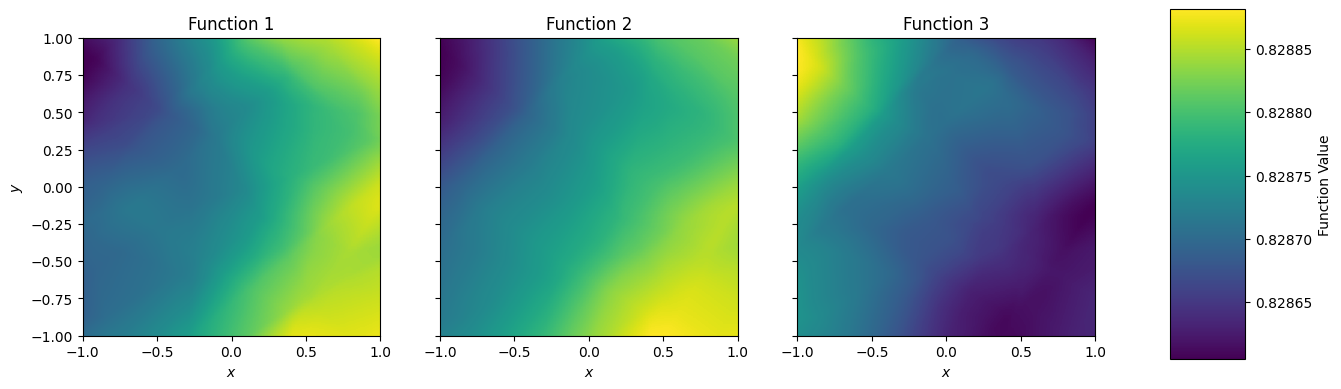

In [11]:
#create some test data
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X,Y = np.meshgrid(x,y)
coordinates = np.stack([X.flatten(),
                        Y.flatten()]).T

#make a dataloader
coordinates_tensor = torch.tensor(coordinates, dtype=torch.float32).to(device)

# Evaluate the neural network
model.eval()
outputs = model(coordinates_tensor)
outputs = outputs.cpu().detach().numpy()
outputs = outputs.reshape(100,100,3)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
fig.subplots_adjust(right=0.8)

cmap="viridis"
titles=['Function 1', 'Function 2', 'Function 3']
for idx in range(3):
    im = axs[idx].imshow(outputs[:,:,idx], extent=[-1, 1, -1 ,1], origin='lower', cmap=cmap)
    axs[idx].set_xlabel('$x$')
    axs[idx].set_title(titles[idx])

axs[0].set_ylabel('$y$')

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Function Value')

#plt.savefig('approximated_function.png', dpi=300, bbox_inches='tight')
#plt.close()
plt.show()

In [12]:
#test the model on 10 independent samples, recording the mean mae and mse and the standard deviation of the mae and mse
n_samples = 10
mae = np.zeros(n_samples)
mse = np.zeros(n_samples)
for i in range(n_samples):
    coordinates = np.random.rand(100,2)
    coordinates_tensor = torch.tensor(coordinates, dtype=torch.float32).to(device)
    outputs = model(coordinates_tensor)
    outputs = outputs.cpu().detach().numpy()
    targets = f(coordinates)
    mae[i] = np.mean(np.abs(outputs - targets))
    mse[i] = np.mean((outputs - targets)**2)
print(f'Mean MAE: {np.mean(mae)} +/- {np.std(mae)}')
print(f'Mean MSE: {np.mean(mse)} +/- {np.std(mse)}')



Mean MAE: 0.8433852670560908 +/- 0.03566908215976481
Mean MSE: 1.0488583902383797 +/- 0.08270621664166791


In [13]:
# Create the neural network
COSGDmodel = Net().to(device)
#define the optimizer
optimizer = COSGD(COSGDmodel.parameters(), lr=0.001)
#define the loss function
criterion = nn.MSELoss()
# Train the neural network
COSGDmodel = train_model_cosgd(COSGDmodel, optimizer, dataloaders, criterion, 500) 


C:\Users\rayde\AppData\Local\Temp\ipykernel_28472\1277995152.py:17: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ..\torch\csrc\utils\python_arg_parser.cpp:1485.)
  p.data.add_(-group['lr'], d_p)


Epoch 1/500 Loss : 0.9241695404052734
Epoch 2/500 Loss : 1.0554617643356323
Epoch 3/500 Loss : 0.9886519312858582
Epoch 4/500 Loss : 0.9791346788406372
Epoch 5/500 Loss : 1.2046728134155273
Epoch 6/500 Loss : 0.7366387844085693
Epoch 7/500 Loss : 1.0940325260162354
Epoch 8/500 Loss : 1.0197714567184448
Epoch 9/500 Loss : 0.9132050275802612
Epoch 10/500 Loss : 0.7755915522575378
Epoch 11/500 Loss : 1.0514708757400513
Epoch 12/500 Loss : 0.8882917165756226
Epoch 13/500 Loss : 0.9726969599723816
Epoch 14/500 Loss : 0.9237882494926453
Epoch 15/500 Loss : 1.0111277103424072
Epoch 16/500 Loss : 1.1087125539779663
Epoch 17/500 Loss : 0.983489990234375
Epoch 18/500 Loss : 1.0867561101913452
Epoch 19/500 Loss : 1.081225872039795
Epoch 20/500 Loss : 1.3870060443878174
Epoch 21/500 Loss : 1.2480223178863525
Epoch 22/500 Loss : 1.3002760410308838
Epoch 23/500 Loss : 1.1375645399093628
Epoch 24/500 Loss : 0.8260247111320496
Epoch 25/500 Loss : 1.052011489868164
Epoch 26/500 Loss : 0.830141663551330

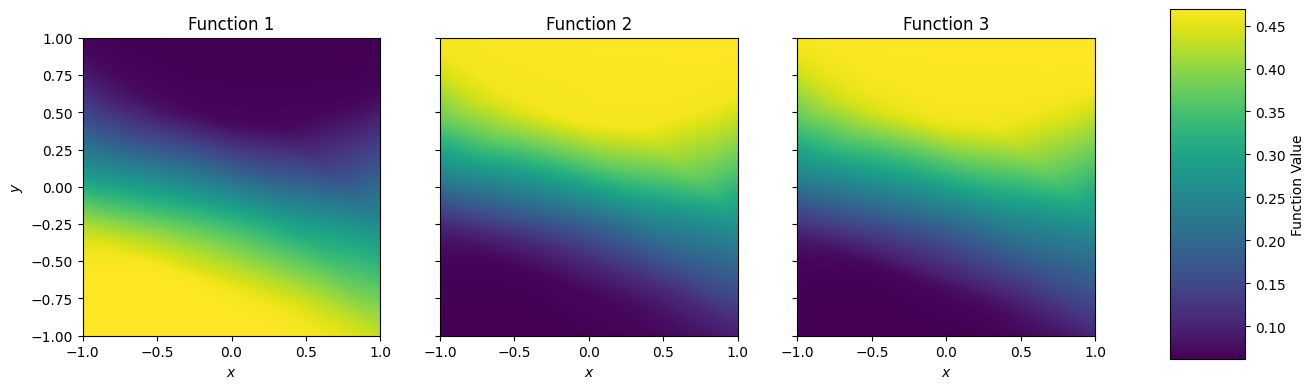

In [14]:
#create some test data
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X,Y = np.meshgrid(x,y)
coordinates = np.stack([X.flatten(),
                        Y.flatten()]).T

#make a dataloader
coordinates_tensor = torch.tensor(coordinates, dtype=torch.float32).to(device)

# Evaluate the neural network
COSGDmodel.eval()
outputs = COSGDmodel(coordinates_tensor)
outputs = outputs.cpu().detach().numpy()
outputs = outputs.reshape(100,100,3)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
fig.subplots_adjust(right=0.8)

cmap="viridis"

titles=['Function 1', 'Function 2', 'Function 3']
for idx in range(3):
    im = axs[idx].imshow(outputs[:,:,idx], extent=[-1, 1, -1 ,1], origin='lower', cmap=cmap)
    axs[idx].set_xlabel('$x$')
    axs[idx].set_title(titles[idx])

axs[0].set_ylabel('$y$')

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Function Value')

#plt.savefig('approximated_function_cosgd.png', dpi=300, bbox_inches='tight')
#plt.close()
plt.show()

In [15]:
#test the model on 10 independent samples, recording the mean mae and mse and the standard deviation of the mae and mse
n_samples = 10
mae = np.zeros(n_samples)
mse = np.zeros(n_samples)
for i in range(n_samples):
    coordinates = np.random.rand(100,2)
    coordinates_tensor = torch.tensor(coordinates, dtype=torch.float32).to(device)
    outputs = COSGDmodel(coordinates_tensor)
    outputs = outputs.cpu().detach().numpy()
    targets = f(coordinates)
    mae[i] = np.mean(np.abs(outputs - targets))
    mse[i] = np.mean((outputs - targets)**2)
print(f'Mean MAE: {np.mean(mae)} +/- {np.std(mae)}')
print(f'Mean MSE: {np.mean(mse)} +/- {np.std(mse)}')

Mean MAE: 0.7700383293468792 +/- 0.03341417739412907
Mean MSE: 0.8961412714492726 +/- 0.048703135670441496
